In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Brief look at the table

In [3]:
user_df = pd.read_csv("takehome_users.csv", encoding = "ISO-8859-1")
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [146]:
engagement_df = pd.read_csv("takehome_user_engagement.csv", encoding = "ISO-8859-1")
print(engagement_df.shape)
engagement_df.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


#### Identify "Adopted Users"
Use the user engagement table, for each login, find the time since the second last login. The adopted users are those with at least one login that is within 7 days of the second last login.

In [147]:
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])
engagement_df['date'] = engagement_df['time_stamp'].apply(pd.Timestamp.date)
engagement_df = engagement_df.groupby(['user_id','date']).first().reset_index()
engagement_df['diff'] = engagement_df.groupby('user_id')['time_stamp'].diff(2)
target = engagement_df.groupby('user_id')['diff'].min() <= '7 days'

Merge engagement table to user information table. For those user who do not have engagement record, we mark them as "unadopted user" by definition. We found there are 1656 adopted users adn 10344 unadopted users.

False    10344
True      1656
Name: target, dtype: int64


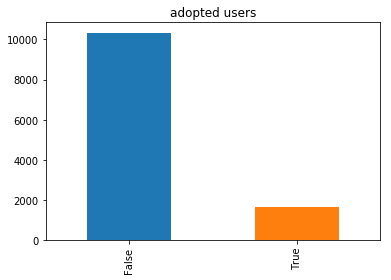

In [129]:
user_df['target'] = user_df['object_id'].map(target)
user_df['target'].fillna(False, inplace=True)
adopted_user = user_df['target'].value_counts()
print(adopted_user)
adopted_user.plot.bar()
plt.title("adopted users")
plt.show()

#### Look at some variables that may related to adopted user

Users signed up with google account or invited by guests are more likely being adopted. Users who are invited to join another user's personal workspace are less likely to be adopted.

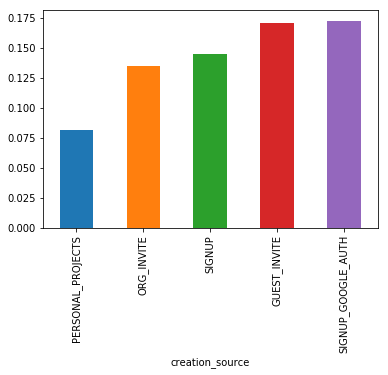

In [130]:
user_df.groupby('creation_source')['target'].mean().sort_values().plot.bar()
plt.show()

Users who are in the mailing list or subscripting the marketing emails are more likely to use the product. However, the difference it not very significant. Quite a lot active users do not opt in mailing list, perhaps the ad contents are not interest enough.

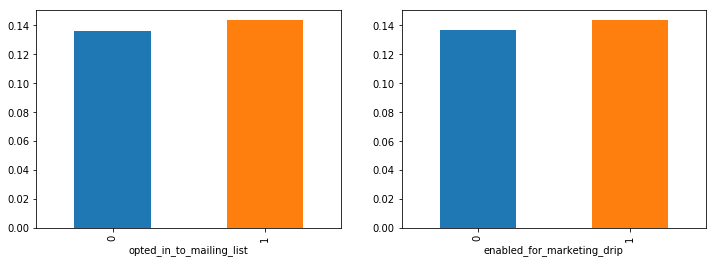

In [131]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
user_df.groupby('opted_in_to_mailing_list')['target'].mean().plot.bar()
plt.subplot(1,2,2)
user_df.groupby('enabled_for_marketing_drip')['target'].mean().plot.bar()
plt.show()

User registered with certain email domains are more likely to be adopted users.

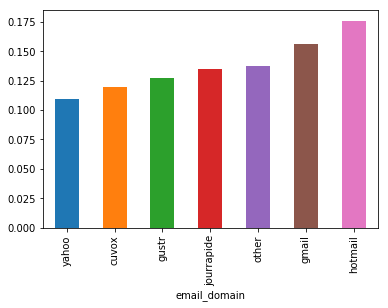

In [192]:
user_df['email_domain'] = user_df['email'].str.findall('@.+\.').apply(lambda x: x[0][1:-1])
user_df['email_domain'].loc[~user_df['email_domain'].isin(email_domains)] = 'other'
email_domains = ['gmail','yahoo','jourrapide','cuvox','gustr','hotmail']
mean_by_email = user_df.groupby('email_domain')['target'].mean().sort_values()
mean_by_email.plot.bar()
plt.show()

#### Month since account creation when become an "adopted user"

We find for the 1656 adopted users, the majority of them qualify as adopted user within 3 months of creating their account. This suggest it is unlikely for people who haven't use their account for a long time to become active again. We can try to figure out if their is anyway to bring back those old customers. Also, this means it is important to make customs interested in the product in a short period of time.

1656


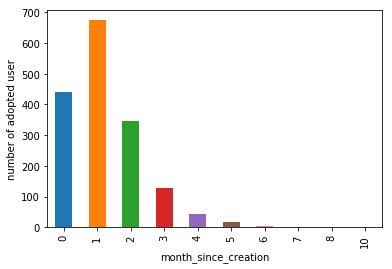

In [174]:
user_df['creation_time'] = pd.to_datetime(user_df['creation_time'])
creation_time = pd.Series(user_df['creation_time'].values, index=user_df['object_id'].values)
engagement_df['creation_time'] = engagement_df['user_id'].map(creation_time)
engagement_df['time_since_creation'] = engagement_df['time_stamp'] - engagement_df['creation_time']
engagement_df['month_since_creation'] = (engagement_df['time_since_creation'].apply(lambda x: int(str(x).split()[0]))/30).astype('int')

first_adopted_df = engagement_df.loc[engagement_df['diff']<='7 day'].groupby('user_id').first().reset_index()
n_adopted = first_adopted_df.groupby('month_since_creation')['user_id'].nunique()
n_adopted.plot.bar()
print(n_adopted.sum())
plt.ylabel("number of adopted user")
plt.show()